In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
from os.path import join
import torch
import matplotlib.pyplot as plt
sys.path.append("/n/netscratch/konkle_lab/Everyone/Jingxuan/DiffusionObjectRelation/PixArt-alpha")
from diffusion.utils.misc import read_config, set_random_seed, \
    init_random_seed, DebugUnderflowOverflow
sys.path.append("/n/netscratch/konkle_lab/Everyone/Jingxuan/DiffusionObjectRelation")
from utils.pixart_sampling_utils import visualize_prompts, PixArtAlphaPipeline_custom, \
    load_embed_and_mask#, visualize_prompts_with_traj
from utils.pixart_utils import construct_diffuser_pipeline_from_config, construct_pixart_transformer_from_config, state_dict_convert
from utils.attention_map_store_utils import replace_attn_processor, AttnProcessor2_0_Store, PixArtAttentionVisualizer_Store
import psutil
import time
import os
import numpy as np
import re


/n/home03/fjxdaisy/.conda/envs/torch2/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/n/home03/fjxdaisy/.conda/envs/torch2/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


### Load models and tokenizer

In [4]:
savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot"
ckptdir = join(savedir, "checkpoints")
config = read_config(join(savedir, 'config.py'))
#weight_dtype = torch.float32
config.mixed_precision = "bf16"
if config.mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif config.mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16
# fp16 will have overflow problem
# bf16 and float32 are good. 

### Load pretrained model

In [5]:
# Load the pretrained PixArt Alpha model from Hugging Face
model_name = "PixArt-alpha/PixArt-XL-2-512x512"
pipeline = PixArtAlphaPipeline_custom.from_pretrained(model_name,torch_dtype = weight_dtype)
pipeline = pipeline.to("cuda")
tokenizer = pipeline.tokenizer

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of the model checkpoint were not used when initializing PixArtTransformer2DModel: 
 ['caption_projection.y_embedding']


In [6]:

torch.cuda.empty_cache()  # Frees unused GPU memory
torch.cuda.ipc_collect()  # Collects and releases memory from shared tensors


### Example workflow using one prompt example

In [7]:
# prompts
validation_prompts = [
 'cat is to the left of dog']
index = 0

#### Get object and position token indices

In [8]:
import spacy

# Load the spaCy English model (make sure to install it via "python -m spacy download en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

def get_meaningful_token_indices(prompt: str):
    """
    Extract indices and token strings for two objects and a spatial relationship from a prompt.
    
    The function assumes that the prompt contains at least two noun tokens (object entities)
    and one spatial relationship token (from a predefined list). It returns the index and text 
    for the first and last noun tokens as object1 and object2, and the first spatial token found.
    
    Parameters:
        prompt (str): The input prompt (e.g., "cat is to the left of dog").
    
    Returns:
        dict: A dictionary with keys:
            - "object1_index": Index of the first object token.
            - "object1_text": Text of the first object token.
            - "spatial": Index of the spatial relationship token.
            - "spatial_text": Text of the spatial token.
            - "object2_index": Index of the second object token.
            - "object2_text": Text of the second object token.
            
    Raises:
        ValueError: If the prompt does not contain at least two noun tokens and one spatial token.
    """
    # Define a set of spatial keywords (expandable based on your use-case)
    spatial_keywords = {"left", "right", "above", "below", "behind", "front", "center", "top", "bottom"}
    
    doc = nlp(prompt)
    
    # Collect noun tokens (both index and text)
    noun_tokens = [(token.i, token.text) for token in doc if token.pos_ in {"NOUN", "PROPN"}]
    
    # Find the first token whose lowercase text is in our spatial keywords list
    spatial_index = None
    spatial_token_text = None
    for token in doc:
        if token.text.lower() in spatial_keywords:
            spatial_index = token.i
            spatial_token_text = token.text
            break
    
    # Check that we have at least two object tokens and one spatial token
    if noun_tokens and spatial_index is not None and len(noun_tokens) >= 2:
        object1_index, object1_text = noun_tokens[0]
        object2_index, object2_text = noun_tokens[-1]
        return {
            "object1_index": object1_index,
            "object1_text": object1_text,
            "spatial": spatial_index,
            "spatial_text": spatial_token_text,
            "object2_index": object2_index,
            "object2_text": object2_text,
        }
    else:
        raise ValueError("Prompt parsing failed. Ensure the prompt contains two object entities and one spatial relationship.")


In [9]:
prompt = validation_prompts[index]
indices = get_meaningful_token_indices(prompt)
print(indices)
# Expected output: {'object1': 0, 'spatial': 4, 'object2': 6}

{'object1_index': 0, 'object1_text': 'cat', 'spatial': 4, 'spatial_text': 'left', 'object2_index': 6, 'object2_text': 'dog'}


#### Inference and visualize attention mask

In [10]:
@torch.inference_mode()
def visualize_prompts_with_traj(pipeline, validation_prompts, num_inference_steps=14, guidance_scale=4.5, 
                                num_images_per_prompt=1, device=torch.device("cuda"), random_seed=0, weight_dtype=torch.bfloat16):

    # Move pipeline to GPU (or multi-GPU)
    pipeline.to(device)
    pipeline.set_progress_bar_config(disable=True)

    # Set up generator
    if random_seed is None:
        generator = None
    else:
        generator = torch.Generator(device=device).manual_seed(random_seed)
    #image_logs = []
    #print(generator.device.type)
    image_logs, images, latents, pred_traj, latents_traj, t_traj, visualized_prompts = [], [], [], [], [], [], []

    for prompt in validation_prompts:
        # Run pipeline
        output = pipeline(
            prompt=prompt,
            num_inference_steps=num_inference_steps,
            num_images_per_prompt=num_images_per_prompt,
            generator=generator,
            guidance_scale=guidance_scale,
            use_resolution_binning=False,
            return_sample_pred_traj=True,
            output_type="latent",
            device=device,
        )
        # Store latents and trajectories
        latents.append(output[0].images)
        pred_traj.append(output[1])
        latents_traj.append(output[2])
        t_traj.append(output[3])
        visualized_prompts.append(prompt)

    for latent in latents:
        images.append(pipeline.vae.decode(latent.to(weight_dtype) / pipeline.vae.config.scaling_factor, return_dict=False)[0])

    # Postprocess images (small VRAM impact)
    for prompt, image in zip(visualized_prompts, images):
        image = pipeline.image_processor.postprocess(image, output_type="pil")
        image_logs.append({"validation_prompt": prompt, "images": image})
    print("Function execution complete!")
    return image_logs, latents_traj, pred_traj, t_traj



In [11]:
pipeline.transformer = replace_attn_processor(pipeline.transformer)
attnvis_store = PixArtAttentionVisualizer_Store(pipeline)
attnvis_store.setup_hooks()

Setting up hooks for PixArt attention modules:
- Block 0
- Block 1
- Block 2
- Block 3
- Block 4
- Block 5
- Block 6
- Block 7
- Block 8
- Block 9
- Block 10
- Block 11
- Block 12
- Block 13
- Block 14
- Block 15
- Block 16
- Block 17
- Block 18
- Block 19
- Block 20
- Block 21
- Block 22
- Block 23
- Block 24
- Block 25
- Block 26
- Block 27


In [12]:
attnvis_store.clear_activation()
image_logs, latents_traj, pred_traj, t_traj = visualize_prompts_with_traj(\
    pipeline, validation_prompts[index:index+1], num_inference_steps=14, guidance_scale=4.5, 
                                num_images_per_prompt=1, device=torch.device("cuda"), random_seed=1, weight_dtype=weight_dtype)
#embed_infos = load_embed_and_mask(validation_prompts[index:index+1], prompt_cache_dir, config.model_max_length, device=torch.device("cuda"))

# attention_mask_raw = embed_infos[0]['emb_mask'].cpu()
token_ids = tokenizer.encode(prompt)
word_tokens = tokenizer.convert_ids_to_tokens(token_ids)
word_tokens = [token.replace("▁", "") for token in word_tokens]

torch.Size([2, 120, 4096])
torch.Size([2, 120])
Function execution complete!


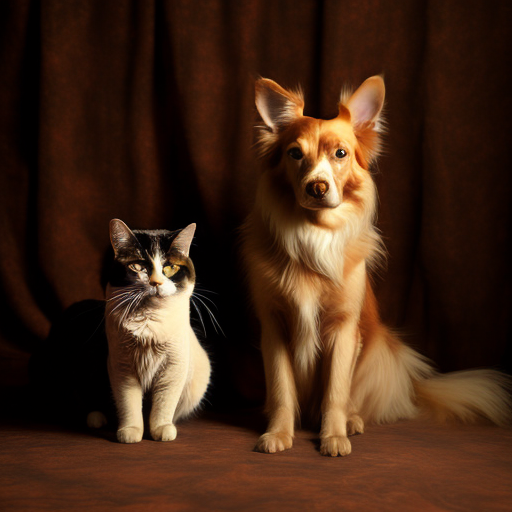

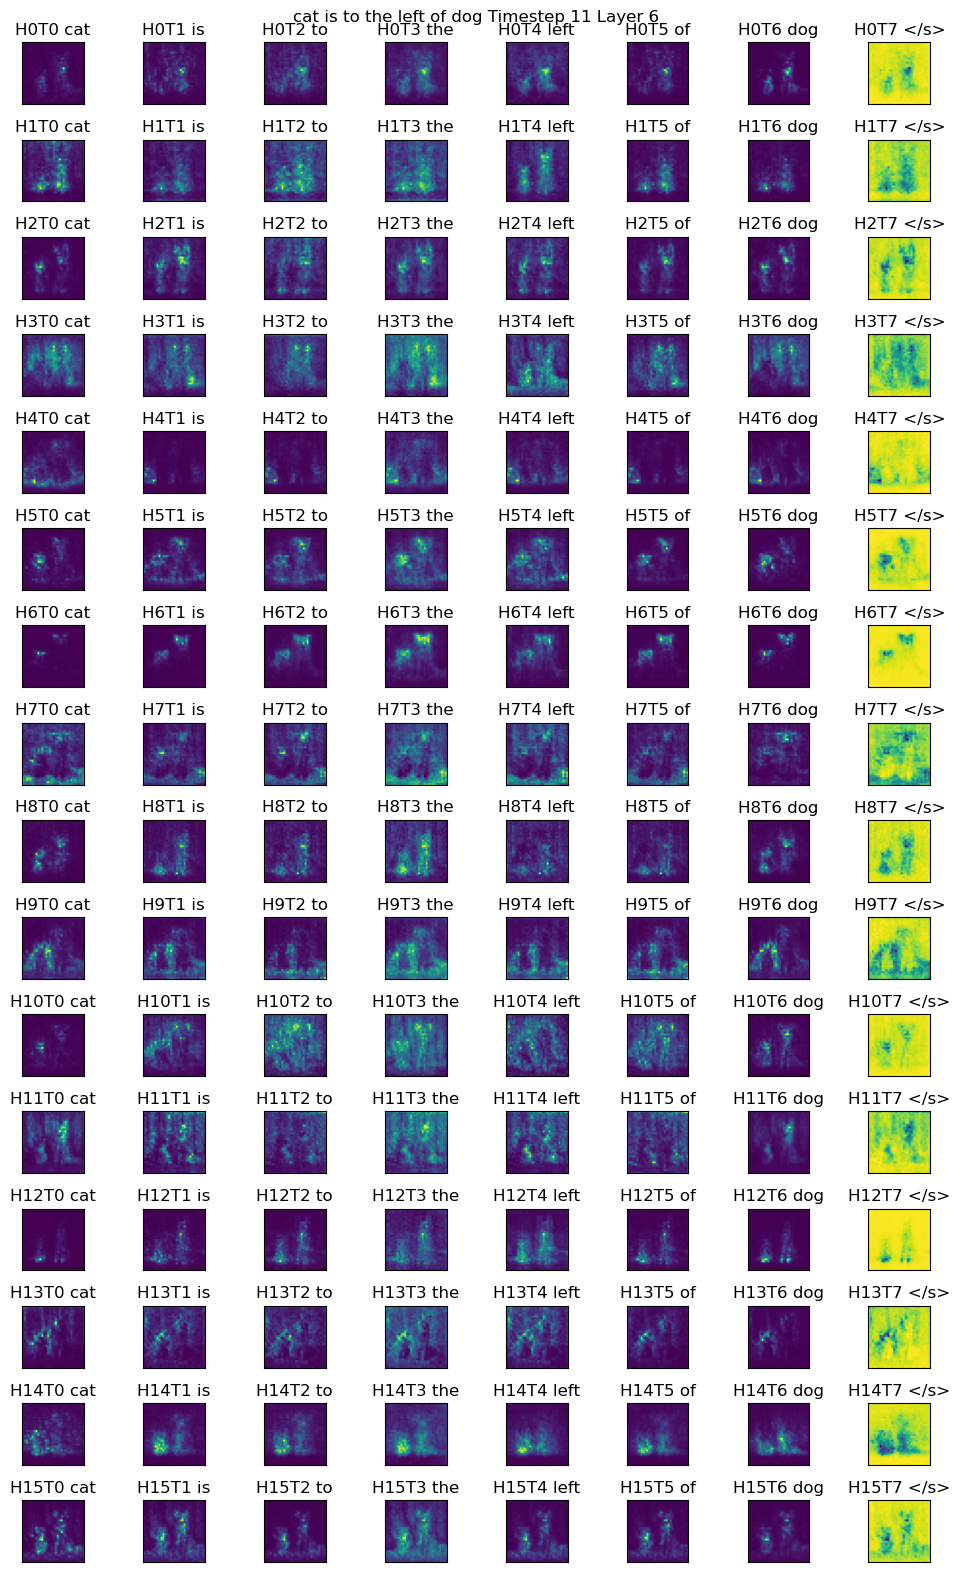

In [13]:
layer_i = 6 # note the 
timestep = 11
self_attn_map = attnvis_store.activation[f'block{layer_i:02d}_self_attn_map'][timestep]
cross_attn_map = attnvis_store.activation[f'block{layer_i:02d}_cross_attn_map'][timestep]
sample_id = 0
display(image_logs[0]['images'][sample_id])
figh, axs = plt.subplots(16, len(word_tokens), figsize=(10, 16))
for head_id in range(16):
    for token_id in range(len(word_tokens)):
        ax = axs[head_id, token_id]
        ax.imshow(cross_attn_map[sample_id+1, 
                                 head_id, :, 
                                 token_id].view(32, 32).float().cpu().numpy())
        ax.axis('image')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title(f'H{head_id}T{token_id} {word_tokens[token_id]}')
        
plt.suptitle(f'{prompt} Timestep {timestep} Layer {layer_i}')
plt.tight_layout()


#### Get object masks

Note: measure where object is in the image -> pretrained segmentation model: https://github.com/facebookresearch/sam2


In [14]:

def get_image_path(prompt: str, base_dir="example_images", filename="generated_image.png") -> str:
    """
    Convert a prompt string into a safe directory name, create the directory, and return the full image path.
    
    Parameters:
        prompt (str): The prompt text (e.g., "cat is to the left of dog").
        base_dir (str): The base directory under which images are stored.
        filename (str): The name of the image file.
        
    Returns:
        str: The full path for the generated image.
    """
    # Replace spaces (and any consecutive whitespace) with underscores
    safe_prompt = re.sub(r'\s+', '_', prompt.strip())
    
    # Construct the directory path and create it if it doesn't exist
    dir_path = os.path.join(base_dir, safe_prompt)
    os.makedirs(dir_path, exist_ok=True)
    
    # Return the full image path
    return os.path.join(dir_path, filename)



image_path = get_image_path(prompt)
image_logs[0]['images'][sample_id].save(image_path)
print("Image saved to:", image_path)


Image saved to: example_images/cat_is_to_the_left_of_dog/generated_image.png


/n/home03/fjxdaisy/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home03/fjxdaisy/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Found 1 mask(s) for dog


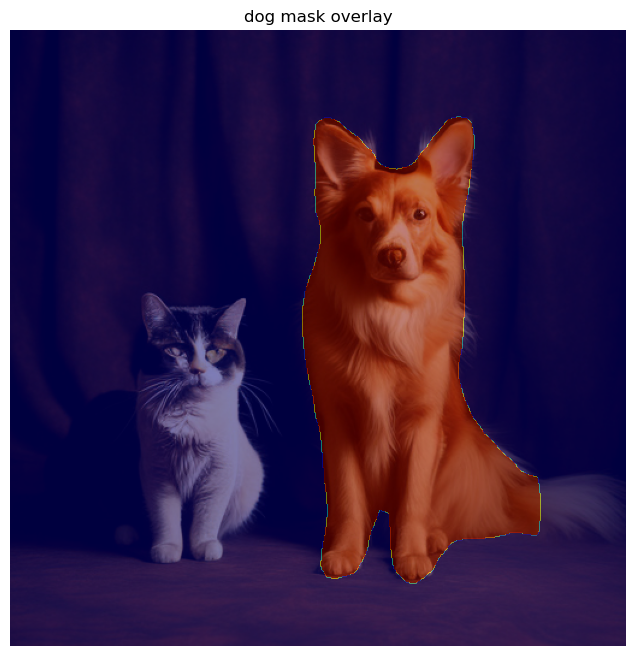

Found 1 mask(s) for cat


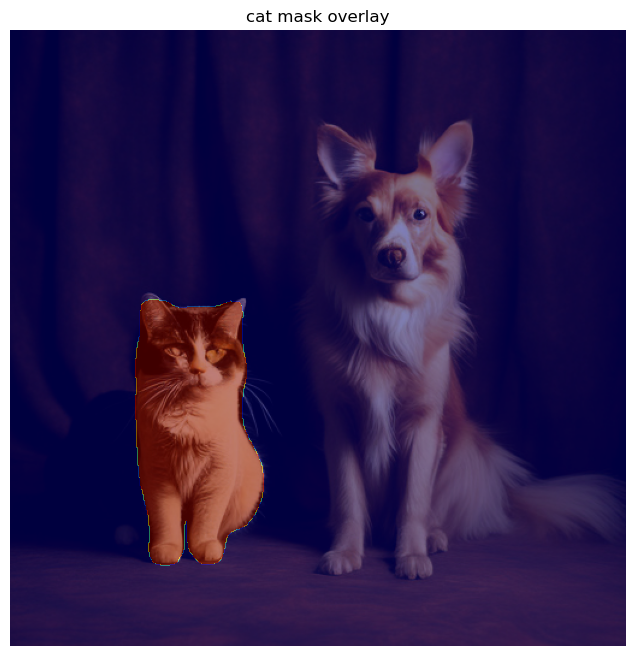

In [15]:
import torch
import torchvision
from torchvision import transforms as T
from PIL import Image
import numpy as np

# Full list of COCO instance category names.
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
    'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase',
    'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork',
    'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
    'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A',
    'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def segment_objects(image: Image.Image, obj1: str, obj2: str, confidence_threshold: float = 0.7):
    """
    Use Mask R-CNN (pre-trained on COCO) to segment objects in the image,
    filtering predictions for the two provided object strings.
    
    Parameters:
      image: PIL.Image.Image
          The generated image.
      obj1: str
          The first object to search for (e.g., "cat").
      obj2: str
          The second object to search for (e.g., "dog").
      confidence_threshold: float
          Minimum score to consider a detection valid.
    
    Returns:
      dict: A dictionary mapping detected object classes (lowercase) to their masks.
            For example, {'cat': [mask1, mask2], 'dog': [mask3]}.
    """
    # Load a pre-trained Mask R-CNN model.
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    model.eval()
    
    # Define transformation.
    transform = T.Compose([T.ToTensor()])
    img_tensor = transform(image)
    
    # Forward pass through the model.
    with torch.no_grad():
        predictions = model([img_tensor])[0]
    
    
    # Convert provided object names to lowercase for matching.
    target_objs = {obj1.lower(), obj2.lower()}
    
    object_masks = {}
    for i, label in enumerate(predictions["labels"].tolist()):
        score = predictions["scores"][i].item()
        if score < confidence_threshold:
            continue
        
        class_name = COCO_INSTANCE_CATEGORY_NAMES[label]
        if class_name.lower() in target_objs:
            # Extract and process the mask.
            mask = predictions["masks"][i, 0].mul(255).byte().cpu().numpy()
            mask = (mask > 127).astype(np.uint8)
            key = class_name.lower()
            object_masks.setdefault(key, []).append(mask)
    
    return object_masks


#image_path = "example_images/cat_left_dog.png"
#image_0 = Image.open(image_path)
masks = segment_objects(image_logs[0]['images'][sample_id],"cat", "dog")

import pickle
mask_path = get_image_path(prompt,filename="mask.pkl")
with open(mask_path, "wb") as f:
    pickle.dump(masks, f)
# overlay the mask on the image
for obj, mask_list in masks.items():
    print(f"Found {len(mask_list)} mask(s) for {obj}")
    mask = mask_list[0]  # Use the first mask for demonstration

    # Convert the original image to a numpy array
    image_np = np.array(image_logs[0]['images'][sample_id])

    # Create a figure and axis
    plt.figure(figsize=(8, 8))
    plt.imshow(image_np)
    # Overlay the mask: use a colormap (e.g., "jet") and set transparency with alpha
    plt.imshow(mask, cmap="jet", alpha=0.5)
    plt.title(f"{obj} mask overlay")
    plt.axis("off")
    plt.show()
#### Compute metrics

#### Compute metrics

##### Useful functions

In [16]:
import numpy as np
import cv2
import scipy.stats
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mutual_info_score
from skimage.metrics import structural_similarity as ssim

def compute_iou(mask1: np.ndarray, mask2: np.ndarray) -> float:
    """
    Compute the Intersection over Union (IoU) between two binary masks.
    """
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union != 0 else 0.0

def compute_dice(mask1: np.ndarray, mask2: np.ndarray) -> float:
    """
    Compute the Dice coefficient (F1 score) between two binary masks.
    """
    intersection = np.logical_and(mask1, mask2).sum()
    sum_masks = mask1.sum() + mask2.sum()
    return 2 * intersection / sum_masks if sum_masks > 0 else 0.0

def compute_pearson(att_map: np.ndarray, seg_mask: np.ndarray) -> float:
    """
    Compute the Pearson correlation coefficient between two maps.
    Typically, the attention map is continuous while seg_mask may be binary.
    """
    return scipy.stats.pearsonr(att_map.flatten(), seg_mask.flatten())[0]

def compute_spearman(att_map: np.ndarray, seg_mask: np.ndarray) -> float:
    """
    Compute the Spearman rank correlation coefficient between two maps.
    """
    return scipy.stats.spearmanr(att_map.flatten(), seg_mask.flatten())[0]

def compute_cosine_similarity(att_map: np.ndarray, seg_mask: np.ndarray) -> float:
    """
    Compute the cosine similarity between the flattened versions of two maps.
    """
    att_vector = att_map.flatten().reshape(1, -1)
    seg_vector = seg_mask.flatten().reshape(1, -1)
    return cosine_similarity(att_vector, seg_vector)[0, 0]

def compute_centroid(mask: np.ndarray):
    """
    Compute the centroid (center of mass) of a binary mask.
    Returns a tuple (row, col) or None if mask is empty.
    """
    indices = np.argwhere(mask)
    if indices.size == 0:
        return None
    return indices.mean(axis=0)

def compute_centroid_distance(mask1: np.ndarray, mask2: np.ndarray) -> float:
    """
    Compute the Euclidean distance between the centroids of two binary masks.
    """
    centroid1 = compute_centroid(mask1)
    centroid2 = compute_centroid(mask2)
    if centroid1 is None or centroid2 is None:
        return np.nan
    return np.linalg.norm(centroid1 - centroid2)

def compute_mutual_information(mask1: np.ndarray, mask2: np.ndarray) -> float:
    """
    Compute the mutual information between two binary masks.
    This treats the flattened arrays as discrete variables.
    """
    flat1 = mask1.flatten()
    flat2 = mask2.flatten()
    return mutual_info_score(flat1, flat2)

def compute_ssim_metric(att_map: np.ndarray, seg_mask: np.ndarray) -> float:
    """
    Compute the Structural Similarity Index (SSIM) between two maps.
    Both maps are normalized to the [0, 1] range before computation.
    """
    att_norm = (att_map - att_map.min()) / (att_map.max() - att_map.min() + 1e-8)
    seg_norm = (seg_mask - seg_mask.min()) / (seg_mask.max() - seg_mask.min() + 1e-8)
    ssim_value, _ = ssim(att_norm, seg_norm, full=True)
    return ssim_value




In [17]:
def get_reshaped_cross_attn(layer_id, time_step, sample_id, head_id, indices, token_key='object1_index', grid_size=32):
    """
    Extract and reshape a cross attention map for a given token.

    Parameters:
      cross_attn_map (torch.Tensor): The cross attention map tensor.
      sample_id (int): The sample index (e.g., for batch indexing).
      head_id (int): The attention head index.
      indices (dict): A dictionary containing token indices (e.g., {"object1_index": int, ...}).
      token_key (str): The key to use from indices to select the token. Default is 'object1_index'.
      grid_size (int): The size of one side of the grid (default 32 for 32x32).

    Returns:
      np.ndarray: A 2D numpy array of shape (grid_size, grid_size) representing the attention map.
    """
    cross_attn_map = attnvis_store.activation[f'block{layer_id:02d}_cross_attn_map'][time_step]
    # Extract the attention vector for the specified token
    attn_map = cross_attn_map[1 + sample_id, head_id, :, indices[token_key]].float().cpu().numpy()
    
    # Remove any singleton dimensions
    attn_map = np.squeeze(attn_map)
    
    # Reshape the flat vector (assumed to have grid_size*grid_size elements) into a 2D array.
    reshaped_attn = attn_map.reshape(grid_size, grid_size)
    
    return reshaped_attn

# Example usage:
# reshaped_map = get_reshaped_cross_attn(cross_attn_map, sample_id, head_id, indices)


def percentile_threshold_mask(attn_map: np.ndarray, percentile: float = 80):
    """
    Convert an attention map to a binary mask using a percentile threshold.
    
    Parameters:
        attn_map (np.ndarray): A 2D attention map (e.g., shape (32, 32)).
        percentile (float): The percentile threshold (0-100). Pixels with values 
                            above this threshold will be set to 1.
                            
    Returns:
        binary_mask (np.ndarray): A binary mask with the same shape as attn_map.
        threshold_value (float): The computed threshold value.
    """
    # Compute the threshold value at the given percentile
    threshold_value = np.percentile(attn_map, percentile)
    
    # Create a binary mask where values above threshold are 1, others 0
    binary_mask = (attn_map >= threshold_value).astype(np.uint8)
    
    return binary_mask, threshold_value


def downsample_mask(mask: np.ndarray, target_shape=(32, 32)) -> np.ndarray:
    """
    Downsample a mask to a target shape.
    
    Parameters:
      mask (np.ndarray): The input mask (e.g., 512x512).
      target_shape (tuple): The desired shape, e.g., (32, 32).
      
    Returns:
      np.ndarray: The resized mask.
    """
    # For binary masks, use nearest neighbor interpolation.
    unique_vals = np.unique(mask)
    if set(unique_vals).issubset({0, 1}):
        interpolation = cv2.INTER_NEAREST
    else:
        interpolation = cv2.INTER_LINEAR
    
    # OpenCV's resize expects size as (width, height)
    downsampled = cv2.resize(mask.astype(np.float32), (target_shape[1], target_shape[0]), interpolation=interpolation)
    
    # If it's binary, threshold the downsampled result.
    if interpolation == cv2.INTER_NEAREST:
        downsampled = (downsampled > 0.5).astype(np.uint8)
    
    return downsampled

# Example usage:
# Suppose seg_mask is your 512x512 segmentation mask.
# Downsample it to 32x32 to compare with a 32x32 attention mask.

def compute_all_metrics(att1: np.ndarray, att2: np.ndarray, att3: np.ndarray,
                       att_mask_1: np.ndarray, att_mask_2: np.ndarray, att_mask_3: np.ndarray,
                       seg_mask_1: np.ndarray, seg_mask_2: np.ndarray) -> dict:
    """
    Compute a suite of metrics comparing:
      - Continuous attention maps (att1 vs. att2 vs. att3)
      - Binary attention masks (att_mask_1 vs. att_mask_2 vs. att_mask_3)
      - For each object:
          * Continuous attention map vs. segmentation mask
          * Binary attention mask vs. segmentation mask
          
    Returns:
      dict: A dictionary with all calculated metrics.
    """
    metrics = {}

    # 1. Compare continuous attention maps between all pairs
    metrics["att_map_comparison"] = {
        "pearson_12": compute_pearson(att1, att2),
        "pearson_13": compute_pearson(att1, att3),
        "pearson_23": compute_pearson(att2, att3),
        "spearman_12": compute_spearman(att1, att2),
        "spearman_13": compute_spearman(att1, att3),
        "spearman_23": compute_spearman(att2, att3),
        "cosine_similarity_12": compute_cosine_similarity(att1, att2),
        "cosine_similarity_13": compute_cosine_similarity(att1, att3),
        "cosine_similarity_23": compute_cosine_similarity(att2, att3),
    }
    
    # 2. Compare binary attention masks between all pairs
    metrics["att_mask_comparison"] = {
        "iou_12": compute_iou(att_mask_1, att_mask_2),
        "iou_13": compute_iou(att_mask_1, att_mask_3),
        "iou_23": compute_iou(att_mask_2, att_mask_3),
        "dice_12": compute_dice(att_mask_1, att_mask_2),
        "dice_13": compute_dice(att_mask_1, att_mask_3),
        "dice_23": compute_dice(att_mask_2, att_mask_3),
        "centroid_distance_12": compute_centroid_distance(att_mask_1, att_mask_2),
        "centroid_distance_13": compute_centroid_distance(att_mask_1, att_mask_3),
        "centroid_distance_23": compute_centroid_distance(att_mask_2, att_mask_3),
        "mutual_information_12": compute_mutual_information(att_mask_1, att_mask_2),
        "mutual_information_13": compute_mutual_information(att_mask_1, att_mask_3),
        "mutual_information_23": compute_mutual_information(att_mask_2, att_mask_3),
    }
    
    # 3. Compare each object's continuous attention map vs. its segmentation mask
    metrics["object1_att_vs_seg"] = {
        "pearson": compute_pearson(att1, seg_mask_1),
        "spearman": compute_spearman(att1, seg_mask_1),
        "cosine_similarity": compute_cosine_similarity(att1, seg_mask_1),
    }
    
    metrics["object2_att_vs_seg"] = {
        "pearson": compute_pearson(att2, seg_mask_2),
        "spearman": compute_spearman(att2, seg_mask_2),
        "cosine_similarity": compute_cosine_similarity(att2, seg_mask_2),
    }
    
    metrics["object3_att_vs_seg1"] = {
        "pearson": compute_pearson(att3, seg_mask_1),
        "spearman": compute_spearman(att3, seg_mask_1),
        "cosine_similarity": compute_cosine_similarity(att3, seg_mask_1),
    }

    metrics["object3_att_vs_seg2"] = {
        "pearson": compute_pearson(att3, seg_mask_2),
        "spearman": compute_spearman(att3, seg_mask_2),
        "cosine_similarity": compute_cosine_similarity(att3, seg_mask_2),
    }
    
    # 4. Compare each object's binary attention mask vs. its segmentation mask
    """ metrics["object1_mask_vs_seg"] = {
        "iou": compute_iou(att_mask_1, seg_mask_1),
        "dice": compute_dice(att_mask_1, seg_mask_1),
        "centroid_distance": compute_centroid_distance(att_mask_1, seg_mask_1),
        "mutual_information": compute_mutual_information(att_mask_1, seg_mask_1)
    }
    
    metrics["object2_mask_vs_seg"] = {
        "iou": compute_iou(att_mask_2, seg_mask_2),
        "dice": compute_dice(att_mask_2, seg_mask_2),
        "centroid_distance": compute_centroid_distance(att_mask_2, seg_mask_2),
        "mutual_information": compute_mutual_information(att_mask_2, seg_mask_2)
    }
    
    metrics["object3_mask_vs_seg"] = {
        "iou": compute_iou(att_mask_3, seg_mask_1),
        "dice": compute_dice(att_mask_3, seg_mask_1),
        "centroid_distance": compute_centroid_distance(att_mask_3, seg_mask_1),
        "mutual_information": compute_mutual_information(att_mask_3, seg_mask_1)
    } """
    
    
    
    return metrics

##### Single layer time example

In [39]:
indices

{'object1_index': 0,
 'object1_text': 'cat',
 'spatial': 4,
 'spatial_text': 'left',
 'object2_index': 6,
 'object2_text': 'dog'}

In [18]:
layer_i = 6 # note the 
time_step = 11
sample_id = 0
head_id = 0
att1 = get_reshaped_cross_attn(layer_i, time_step, sample_id, head_id, indices, token_key='object1_index')
att2 = get_reshaped_cross_attn(layer_i, time_step, sample_id, head_id, indices, token_key='object2_index')
attspatial = get_reshaped_cross_attn(layer_i, time_step, sample_id, head_id, indices, token_key='spatial')

In [19]:
att_mask_1 = percentile_threshold_mask(att1, percentile=80)
att_mask_2 = percentile_threshold_mask(att2, percentile=80)
att_mask_spatial = percentile_threshold_mask(attspatial, percentile=80)
#plt.imshow(att_mask_1[0], cmap='gray')

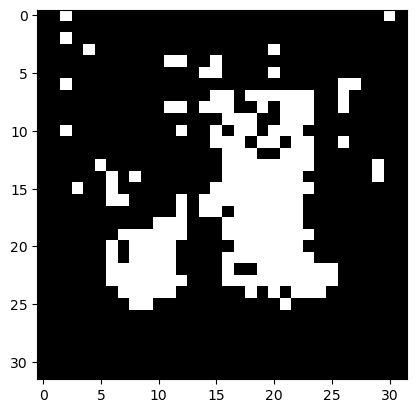

In [43]:
plt.imshow(att_mask_spatial[0], cmap='gray')

In [20]:
seg_mask_1 = masks[indices["object1_text"]][0]
seg_mask_1 = downsample_mask(seg_mask_1, target_shape=(32, 32))
seg_mask_2 = masks[indices["object2_text"]][0]
seg_mask_2 = downsample_mask(seg_mask_2, target_shape=(32, 32))

In [22]:
metrics = compute_all_metrics(att1, att2, attspatial, att_mask_1[0], att_mask_2[0], att_mask_spatial[0], seg_mask_1, seg_mask_2)

##### 1D traverse

- 28 layers 
- 14 time steps
- 16 heads

Example across layers

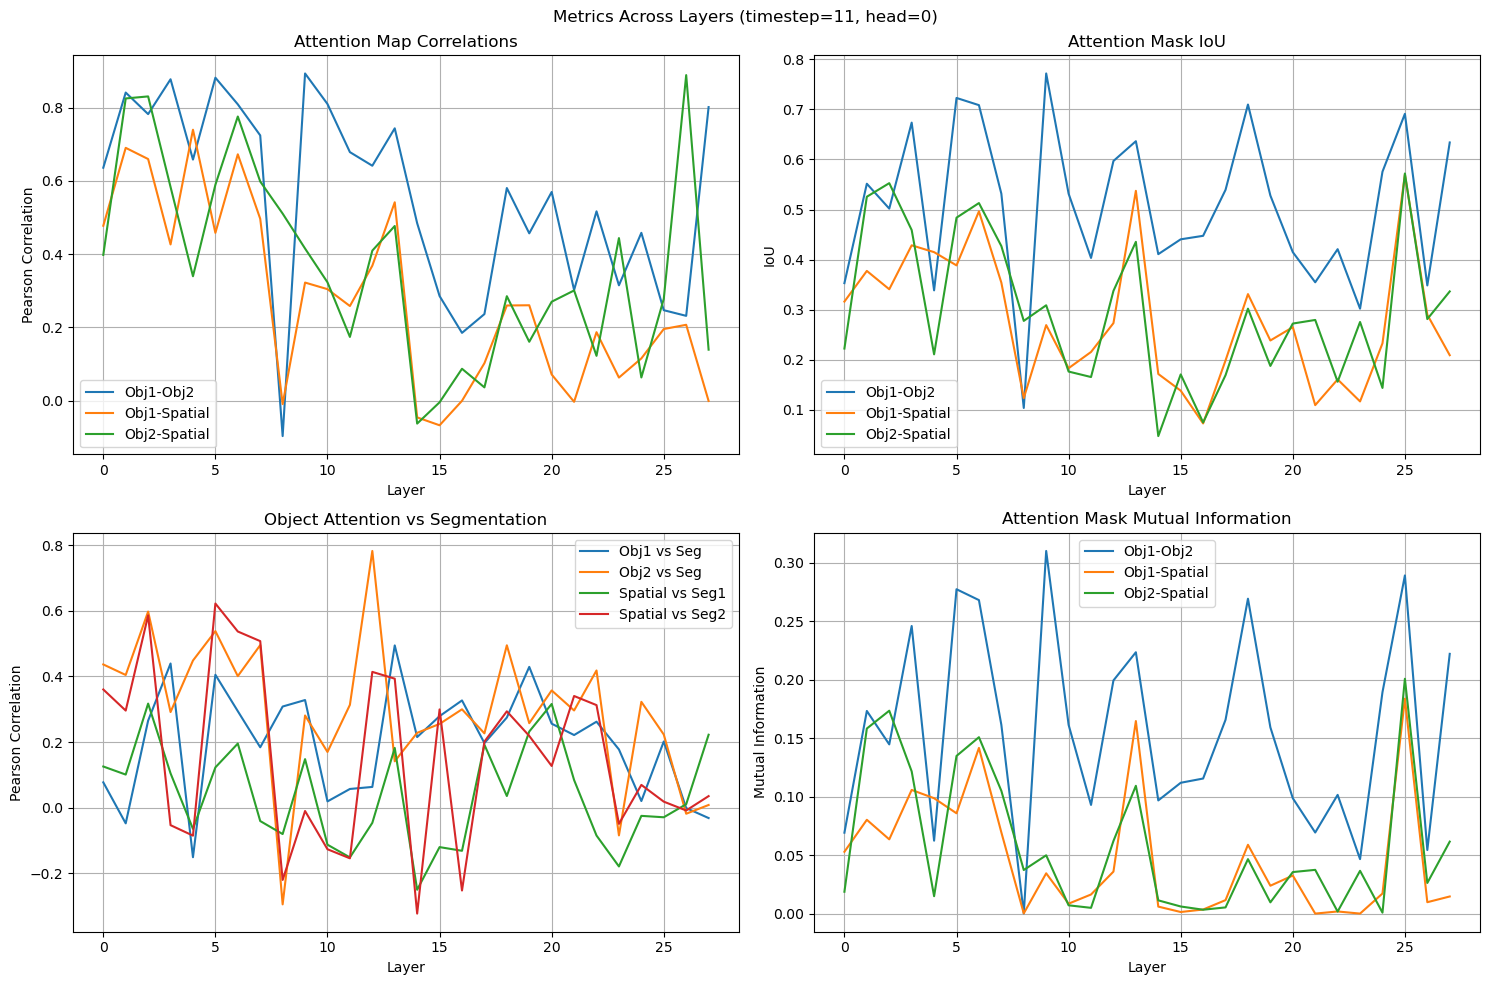


Summary Statistics:

pearson_12:
Best layer: 9
Best value: 0.8937
Mean: 0.5555
Std: 0.2562

Top 3 layers:
Layer 9: 0.8937
Layer 5: 0.8821
Layer 3: 0.8778

pearson_13:
Best layer: 4
Best value: 0.7400
Mean: 0.2768
Std: 0.2403

Top 3 layers:
Layer 4: 0.7400
Layer 1: 0.6905
Layer 6: 0.6728

pearson_23:
Best layer: 26
Best value: 0.8892
Mean: 0.3664
Std: 0.2595

Top 3 layers:
Layer 26: 0.8892
Layer 2: 0.8310
Layer 1: 0.8254

cosine_12:
Best layer: 1
Best value: 0.9565
Mean: 0.6597
Std: 0.2340

Top 3 layers:
Layer 1: 0.9565
Layer 5: 0.9238
Layer 9: 0.9235

cosine_13:
Best layer: 4
Best value: 0.9466
Mean: 0.5076
Std: 0.2565

Top 3 layers:
Layer 4: 0.9466
Layer 1: 0.8965
Layer 0: 0.8808

cosine_23:
Best layer: 1
Best value: 0.9393
Mean: 0.5788
Std: 0.2615

Top 3 layers:
Layer 1: 0.9393
Layer 0: 0.9099
Layer 2: 0.9060

iou_12:
Best layer: 9
Best value: 0.7716
Mean: 0.5087
Std: 0.1533

Top 3 layers:
Layer 9: 0.7716
Layer 5: 0.7227
Layer 18: 0.7095

iou_13:
Best layer: 25
Best value: 0.5698
Me

In [27]:
# Fixed parameters
time_step = 11  # Fixed time step
head_id = 0    # Fixed middle head
sample_id = 0  # First sample
grid_size = 32

# Initialize storage for metrics across layers
layer_metrics = {
    # Attention map comparisons
    'pearson_12': [], 'pearson_13': [], 'pearson_23': [],
    'cosine_12': [], 'cosine_13': [], 'cosine_23': [],
    
    # Attention mask comparisons
    'iou_12': [], 'iou_13': [], 'iou_23': [],
    'mutual_info_12': [], 'mutual_info_13': [], 'mutual_info_23': [],
    
    # Object attention vs segmentation
    'obj1_pearson': [], 'obj2_pearson': [],
    'obj3_pearson_seg1': [], 'obj3_pearson_seg2': []
}

# Loop through layers
for layer_id in range(28):  # 28 layers total
    # Get attention maps for all objects
    att1 = get_reshaped_cross_attn(layer_id, time_step, sample_id, head_id, 
                                 indices, 'object1_index', grid_size)
    att2 = get_reshaped_cross_attn(layer_id, time_step, sample_id, head_id, 
                                 indices, 'object2_index', grid_size)
    att3 = get_reshaped_cross_attn(layer_id, time_step, sample_id, head_id, 
                                 indices, 'spatial', grid_size)
    
    # Create binary masks using percentile thresholding
    att_mask_1, _ = percentile_threshold_mask(att1)
    att_mask_2, _ = percentile_threshold_mask(att2)
    att_mask_3, _ = percentile_threshold_mask(att3)
    
    # Compute all metrics
    metrics = compute_all_metrics(att1, att2, att3, 
                               att_mask_1, att_mask_2, att_mask_3,
                               seg_mask_1, seg_mask_2)
    
    # Store metrics
    # Attention map comparisons
    layer_metrics['pearson_12'].append(metrics['att_map_comparison']['pearson_12'])
    layer_metrics['pearson_13'].append(metrics['att_map_comparison']['pearson_13'])
    layer_metrics['pearson_23'].append(metrics['att_map_comparison']['pearson_23'])
    layer_metrics['cosine_12'].append(metrics['att_map_comparison']['cosine_similarity_12'])
    layer_metrics['cosine_13'].append(metrics['att_map_comparison']['cosine_similarity_13'])
    layer_metrics['cosine_23'].append(metrics['att_map_comparison']['cosine_similarity_23'])
    
    # Attention mask comparisons
    layer_metrics['iou_12'].append(metrics['att_mask_comparison']['iou_12'])
    layer_metrics['iou_13'].append(metrics['att_mask_comparison']['iou_13'])
    layer_metrics['iou_23'].append(metrics['att_mask_comparison']['iou_23'])
    layer_metrics['mutual_info_12'].append(metrics['att_mask_comparison']['mutual_information_12'])
    layer_metrics['mutual_info_13'].append(metrics['att_mask_comparison']['mutual_information_13'])
    layer_metrics['mutual_info_23'].append(metrics['att_mask_comparison']['mutual_information_23'])
    
    # Object attention vs segmentation
    layer_metrics['obj1_pearson'].append(metrics['object1_att_vs_seg']['pearson'])
    layer_metrics['obj2_pearson'].append(metrics['object2_att_vs_seg']['pearson'])
    layer_metrics['obj3_pearson_seg1'].append(metrics['object3_att_vs_seg1']['pearson'])
    layer_metrics['obj3_pearson_seg2'].append(metrics['object3_att_vs_seg2']['pearson'])

# Create line plots
plt.figure(figsize=(15, 10))

# Plot 1: Attention map comparisons (Pearson correlation)
plt.subplot(2, 2, 1)
plt.plot(layer_metrics['pearson_12'], label='Obj1-Obj2')
plt.plot(layer_metrics['pearson_13'], label='Obj1-Spatial')
plt.plot(layer_metrics['pearson_23'], label='Obj2-Spatial')
plt.xlabel('Layer')
plt.ylabel('Pearson Correlation')
plt.title('Attention Map Correlations')
plt.legend()
plt.grid(True)

# Plot 2: Attention mask comparisons (IoU)
plt.subplot(2, 2, 2)
plt.plot(layer_metrics['iou_12'], label='Obj1-Obj2')
plt.plot(layer_metrics['iou_13'], label='Obj1-Spatial')
plt.plot(layer_metrics['iou_23'], label='Obj2-Spatial')
plt.xlabel('Layer')
plt.ylabel('IoU')
plt.title('Attention Mask IoU')
plt.legend()
plt.grid(True)

# Plot 3: Object attention vs segmentation (Pearson)
plt.subplot(2, 2, 3)
plt.plot(layer_metrics['obj1_pearson'], label='Obj1 vs Seg')
plt.plot(layer_metrics['obj2_pearson'], label='Obj2 vs Seg')
plt.plot(layer_metrics['obj3_pearson_seg1'], label='Spatial vs Seg1')
plt.plot(layer_metrics['obj3_pearson_seg2'], label='Spatial vs Seg2')
plt.xlabel('Layer')
plt.ylabel('Pearson Correlation')
plt.title('Object Attention vs Segmentation')
plt.legend()
plt.grid(True)

# Plot 4: Mutual Information
plt.subplot(2, 2, 4)
plt.plot(layer_metrics['mutual_info_12'], label='Obj1-Obj2')
plt.plot(layer_metrics['mutual_info_13'], label='Obj1-Spatial')
plt.plot(layer_metrics['mutual_info_23'], label='Obj2-Spatial')
plt.xlabel('Layer')
plt.ylabel('Mutual Information')
plt.title('Attention Mask Mutual Information')
plt.legend()
plt.grid(True)

plt.suptitle(f'Metrics Across Layers (timestep={time_step}, head={head_id})')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
for metric_name, values in layer_metrics.items():
    print(f"\n{metric_name}:")
    print(f"Best layer: {np.argmax(values)}")
    print(f"Best value: {np.max(values):.4f}")
    print(f"Mean: {np.mean(values):.4f}")
    print(f"Std: {np.std(values):.4f}")
    
    # Print top 3 layers
    top_3_indices = np.argsort(values)[-3:][::-1]
    print("\nTop 3 layers:")
    for idx in top_3_indices:
        print(f"Layer {idx}: {values[idx]:.4f}")

##### 2D traverse

In [23]:
# Fixed parameters
time_step = 11  # Fixed time step
sample_id = 0  # First sample
grid_size = 32
n_heads = 16
n_layers = 28

# Initialize storage for 2D metrics (heads x layers)
metrics_2d = {
    # Attention map comparisons
    'pearson_12': np.zeros((n_heads, n_layers)),
    'pearson_13': np.zeros((n_heads, n_layers)),
    'pearson_23': np.zeros((n_heads, n_layers)),
    'cosine_12': np.zeros((n_heads, n_layers)),
    'cosine_13': np.zeros((n_heads, n_layers)),
    'cosine_23': np.zeros((n_heads, n_layers)),
    
    # Attention mask comparisons
    'iou_12': np.zeros((n_heads, n_layers)),
    'iou_13': np.zeros((n_heads, n_layers)),
    'iou_23': np.zeros((n_heads, n_layers)),
    'mutual_info_12': np.zeros((n_heads, n_layers)),
    'mutual_info_13': np.zeros((n_heads, n_layers)),
    'mutual_info_23': np.zeros((n_heads, n_layers)),
    
    # Object attention vs segmentation
    'obj1_pearson': np.zeros((n_heads, n_layers)),
    'obj2_pearson': np.zeros((n_heads, n_layers)),
    'obj3_pearson_seg1': np.zeros((n_heads, n_layers)),
    'obj3_pearson_seg2': np.zeros((n_heads, n_layers))
}

# Collect metrics for each head-layer combination
for head_id in range(n_heads):
    for layer_id in range(n_layers):
        # Get attention maps for all objects
        att1 = get_reshaped_cross_attn(layer_id, time_step, sample_id, head_id, 
                                     indices, 'object1_index', grid_size)
        att2 = get_reshaped_cross_attn(layer_id, time_step, sample_id, head_id, 
                                     indices, 'object2_index', grid_size)
        attspatial = get_reshaped_cross_attn(layer_id, time_step, sample_id, head_id, 
                                     indices, 'spatial', grid_size)
        
        # Create binary masks using percentile thresholding
        att_mask_1, _ = percentile_threshold_mask(att1)
        att_mask_2, _ = percentile_threshold_mask(att2)
        att_mask_3, _ = percentile_threshold_mask(attspatial)
        
        # Compute all metrics
        metrics = compute_all_metrics(att1, att2, attspatial, 
                                   att_mask_1, att_mask_2, att_mask_3,
                                   seg_mask_1, seg_mask_2)
        
        # Store metrics in 2D arrays
        # Attention map comparisons
        metrics_2d['pearson_12'][head_id, layer_id] = metrics['att_map_comparison']['pearson_12']
        metrics_2d['pearson_13'][head_id, layer_id] = metrics['att_map_comparison']['pearson_13']
        metrics_2d['pearson_23'][head_id, layer_id] = metrics['att_map_comparison']['pearson_23']
        metrics_2d['cosine_12'][head_id, layer_id] = metrics['att_map_comparison']['cosine_similarity_12']
        metrics_2d['cosine_13'][head_id, layer_id] = metrics['att_map_comparison']['cosine_similarity_13']
        metrics_2d['cosine_23'][head_id, layer_id] = metrics['att_map_comparison']['cosine_similarity_23']
        
        # Attention mask comparisons
        metrics_2d['iou_12'][head_id, layer_id] = metrics['att_mask_comparison']['iou_12']
        metrics_2d['iou_13'][head_id, layer_id] = metrics['att_mask_comparison']['iou_13']
        metrics_2d['iou_23'][head_id, layer_id] = metrics['att_mask_comparison']['iou_23']
        metrics_2d['mutual_info_12'][head_id, layer_id] = metrics['att_mask_comparison']['mutual_information_12']
        metrics_2d['mutual_info_13'][head_id, layer_id] = metrics['att_mask_comparison']['mutual_information_13']
        metrics_2d['mutual_info_23'][head_id, layer_id] = metrics['att_mask_comparison']['mutual_information_23']
        
        # Object attention vs segmentation
        metrics_2d['obj1_pearson'][head_id, layer_id] = metrics['object1_att_vs_seg']['pearson']
        metrics_2d['obj2_pearson'][head_id, layer_id] = metrics['object2_att_vs_seg']['pearson']
        metrics_2d['obj3_pearson_seg1'][head_id, layer_id] = metrics['object3_att_vs_seg1']['pearson']
        metrics_2d['obj3_pearson_seg2'][head_id, layer_id] = metrics['object3_att_vs_seg2']['pearson']



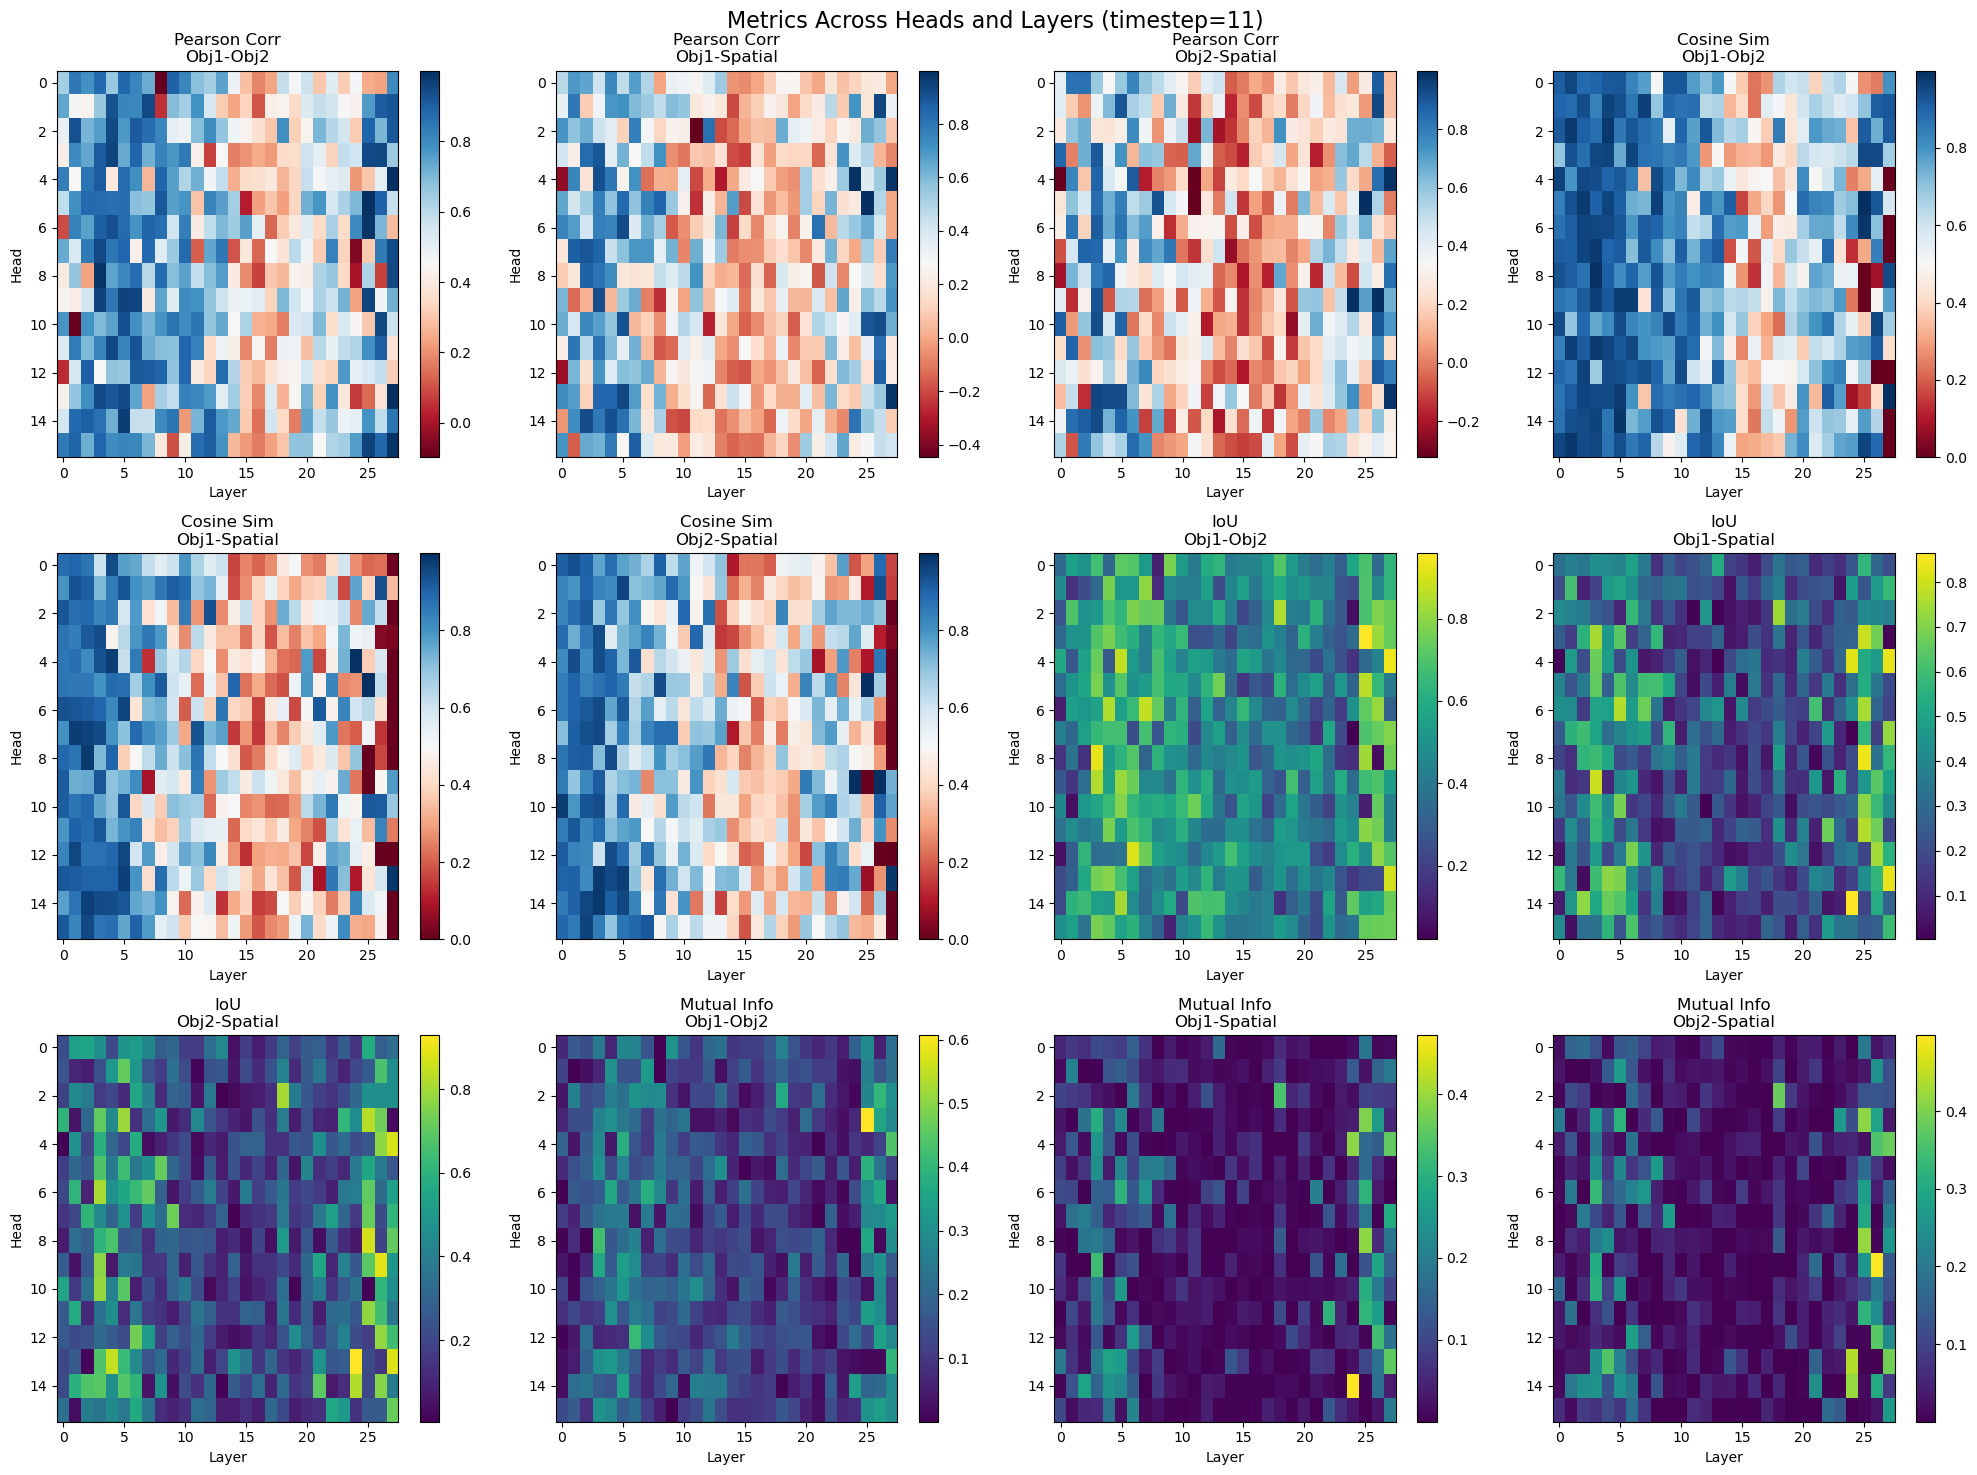


Summary Statistics:

Pearson Corr
Obj1-Obj2:
Best head-layer combination: Head 5, Layer 25
Best value: 1.0000
Mean: 0.5923
Std: 0.2466

Top 3 head-layer combinations:
Head 5, Layer 25: 1.0000
Head 4, Layer 27: 0.9979
Head 13, Layer 27: 0.9976

Pearson Corr
Obj1-Spatial:
Best head-layer combination: Head 5, Layer 25
Best value: 0.9997
Mean: 0.3002
Std: 0.3144

Top 3 head-layer combinations:
Head 5, Layer 25: 0.9997
Head 4, Layer 24: 0.9917
Head 13, Layer 27: 0.9861

Pearson Corr
Obj2-Spatial:
Best head-layer combination: Head 9, Layer 26
Best value: 1.0000
Mean: 0.3179
Std: 0.3083

Top 3 head-layer combinations:
Head 9, Layer 26: 1.0000
Head 9, Layer 24: 1.0000
Head 5, Layer 25: 0.9997

Cosine Sim
Obj1-Obj2:
Best head-layer combination: Head 5, Layer 25
Best value: 1.0000
Mean: 0.6954
Std: 0.2402

Top 3 head-layer combinations:
Head 5, Layer 25: 1.0000
Head 13, Layer 27: 0.9976
Head 8, Layer 3: 0.9922

Cosine Sim
Obj1-Spatial:
Best head-layer combination: Head 5, Layer 25
Best value: 0

In [26]:
# Create heatmap visualizations
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle(f'Metrics Across Heads and Layers (timestep={time_step})', fontsize=16)

# Define metrics to plot and their properties
plot_configs = [
    # Attention map comparisons
    ('pearson_12', 'Pearson Corr\nObj1-Obj2', 'RdBu'),
    ('pearson_13', 'Pearson Corr\nObj1-Spatial', 'RdBu'),
    ('pearson_23', 'Pearson Corr\nObj2-Spatial', 'RdBu'),
    ('cosine_12', 'Cosine Sim\nObj1-Obj2', 'RdBu'),
    ('cosine_13', 'Cosine Sim\nObj1-Spatial', 'RdBu'),
    ('cosine_23', 'Cosine Sim\nObj2-Spatial', 'RdBu'),
    
    # Attention mask comparisons
    ('iou_12', 'IoU\nObj1-Obj2', 'viridis'),
    ('iou_13', 'IoU\nObj1-Spatial', 'viridis'),
    ('iou_23', 'IoU\nObj2-Spatial', 'viridis'),
    ('mutual_info_12', 'Mutual Info\nObj1-Obj2', 'viridis'),
    ('mutual_info_13', 'Mutual Info\nObj1-Spatial', 'viridis'),
    ('mutual_info_23', 'Mutual Info\nObj2-Spatial', 'viridis'),
    
    # Object attention vs segmentation
    ('obj1_pearson', 'Obj1 vs Seg\nPearson', 'RdBu'),
    ('obj2_pearson', 'Obj2 vs Seg\nPearson', 'RdBu'),
    ('obj3_pearson_seg1', 'Spatial vs Seg1\nPearson', 'RdBu'),
    ('obj3_pearson_seg2', 'Spatial vs Seg2\nPearson', 'RdBu')
]

for (metric_key, title, cmap), ax in zip(plot_configs, axes.flat):
    im = ax.imshow(metrics_2d[metric_key], cmap=cmap, aspect='auto')
    ax.set_title(title)
    ax.set_xlabel('Layer')
    ax.set_ylabel('Head')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

# Print summary statistics for each metric
print("\nSummary Statistics:")
for metric_key, title, _ in plot_configs:
    data = metrics_2d[metric_key]
    best_head, best_layer = np.unravel_index(np.argmax(data), data.shape)
    print(f"\n{title}:")
    print(f"Best head-layer combination: Head {best_head}, Layer {best_layer}")
    print(f"Best value: {np.max(data):.4f}")
    print(f"Mean: {np.mean(data):.4f}")
    print(f"Std: {np.std(data):.4f}")
    
    # Print top 3 head-layer combinations
    flat_indices = np.argsort(data.ravel())[-3:][::-1]
    heads, layers = np.unravel_index(flat_indices, data.shape)
    print("\nTop 3 head-layer combinations:")
    for h, l, val in zip(heads, layers, data[heads, layers]):
        print(f"Head {h}, Layer {l}: {val:.4f}")